In [1]:
from sklearn.decomposition import PCA
import numpy as np
import os
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
data_dir = "../data/"

In [3]:
embeddings_path = f"{data_dir}/layer_11_embeddings_30subset.npy"

In [4]:
embeddings = np.load(embeddings_path)

In [5]:
embeddings.shape

(1972, 1003, 768)

In [6]:
num_positions = embeddings.shape[1]

In [7]:
num_positions = embeddings.shape[1]
num_seq = embeddings.shape[0]
k = 20

embeddings_reshaped = embeddings.reshape(-1,768)
embeddings_reshaped.shape

(1977916, 768)

In [8]:
scaler = StandardScaler()
embeddings_reshaped = scaler.fit_transform(embeddings_reshaped)

In [26]:
pca_k = PCA(n_components=k)


pca_k_values = pca_k.fit_transform(embeddings_reshaped)

# Reshape back to per sequence
pca_k_values_reshaped = pca_k_values.reshape(num_seq, num_positions,k)

In [27]:
pca_100 = PCA(n_components=100)
pca_100_values = pca_100.fit_transform(embeddings_reshaped)
pca_100_variance = pca_100.explained_variance_


In [28]:
pca_100.explained_variance_ratio_

array([0.05167516, 0.03523986, 0.02671414, 0.0262849 , 0.02412468,
       0.02162072, 0.0203659 , 0.01753896, 0.0159418 , 0.01498333,
       0.0143833 , 0.01345537, 0.01289257, 0.012492  , 0.01195638,
       0.01115938, 0.01077963, 0.010238  , 0.0101774 , 0.00995214,
       0.00934811, 0.00892673, 0.0088182 , 0.00824811, 0.00814462,
       0.00801632, 0.00782567, 0.00763598, 0.00725091, 0.00714373,
       0.00691146, 0.00670927, 0.00647602, 0.00630059, 0.00617703,
       0.00598377, 0.00590688, 0.00580487, 0.00573844, 0.00565702,
       0.00553621, 0.00542161, 0.00527512, 0.00522677, 0.00505796,
       0.00498981, 0.00488581, 0.00481496, 0.00472197, 0.00466656,
       0.00457675, 0.0045175 , 0.00439782, 0.00428477, 0.00416463,
       0.00415642, 0.00404947, 0.00394034, 0.00391272, 0.00386025,
       0.00375681, 0.00374069, 0.00369289, 0.00368006, 0.0035782 ,
       0.00355786, 0.00350275, 0.00344317, 0.00338533, 0.00333093,
       0.00332134, 0.00320051, 0.0031883 , 0.00312943, 0.00309

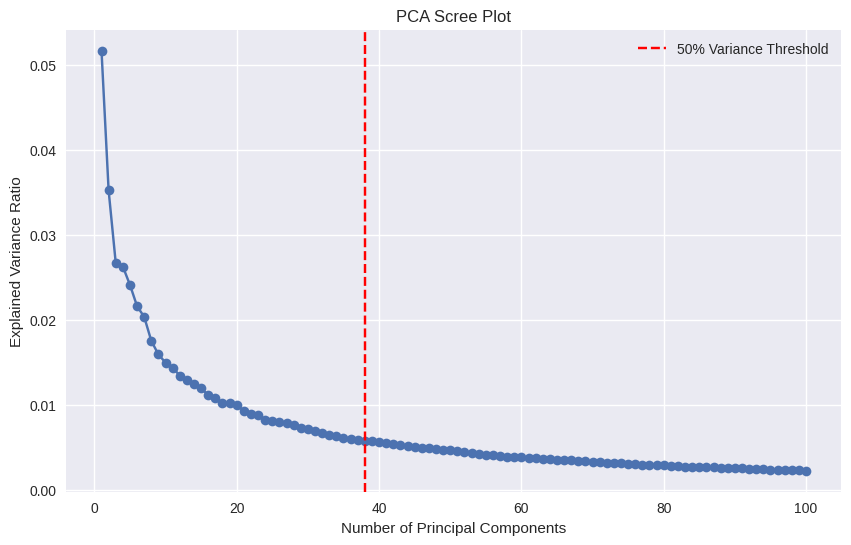

In [94]:
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-deep')
plt.plot(range(1, len(pca_100.explained_variance_ratio_) + 1), pca_100.explained_variance_ratio_, marker='o', linestyle='-')
#Plot line when 95% variance is reached
pca_cum = np.cumsum(pca_100.explained_variance_ratio_)
components_95 = np.where(pca_cum >= 0.50)[0][0] + 1
plt.axvline(x=components_95, color='r', linestyle='--', label='50% Variance Threshold')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.show()

In [30]:
# Cluster embeddings PCA50
kmeans = KMeans(n_clusters=2, random_state=42)
clustering = kmeans.fit_predict(pca_k_values)

# Reshape back with cluster annotation
clustering = clustering.reshape(num_seq, num_positions,1)

In [9]:
# Try clustering on raw embeddings with 32G
kmeans_raw = KMeans(n_clusters=2, random_state=42)
clustering_raw = kmeans_raw.fit_predict(embeddings_reshaped)
# Reshape back with cluster annotation
clustering_raw = clustering_raw.reshape(num_seq, num_positions,1)


In [ ]:
# Try with more clusters
kmeans_5 = KMeans(n_clusters=5, random_state=42)
clustering_5 = kmeans_5.fit_predict(embeddings_reshaped)
# Reshape back with cluster annotation
clustering_5 = clustering_5.reshape(num_seq, num_positions,1)

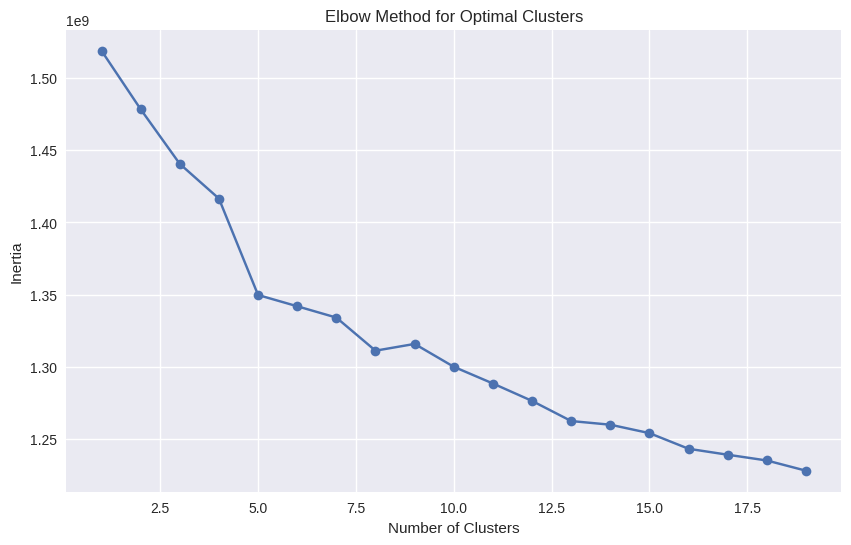

In [24]:
# Make an elbow plot to find optimal number of clusters
inertia = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(embeddings_reshaped)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.grid(True)
plt.show()

In [10]:
clustering_raw.shape

(1972, 1003, 1)

In [31]:
pca_k_values_reshaped.shape

(1972, 1003, 20)

In [43]:
def track_to_bed(
    track: np.ndarray,
    filepath: str,
    track_name: str = "Ground Truth",
    chrom: str = "chr1",
):
    header = f'track name="{track_name}"'
    with open(filepath, "w") as file:
          file.write(f"{header}\n")
    for pos in range(1003):
        score = 0
        if track[pos] > 0:
          score = 1000
          start = pos
          end = pos + 1
          with open(filepath, "a") as file:
            file.write(f"{chrom}\t{start}\t{end}\t{score}\t.\t{start}\t{end}\n")


def track_to_bedgraph(
    track: np.ndarray,
    filepath: str,
    track_name: str = "SAE Activations",
    chrom: str = "chr1",
    coloring: np.ndarray = None
):
    header = f'track type=bedGraph name="{track_name}"'
    with open(filepath, "w") as file:
        file.write(f"{header}\n")
        for pos, value in enumerate(track):
            if value > 0:
                start, end = pos, pos + 1
                if coloring is not None:
                    if coloring[pos] == 1:
                        #red
                        color = "255,0,0"
                    elif coloring[pos] == 0:
                        #blue 
                        color = "0,0,255"
                    file.write(f"{chrom}\t{start}\t{end}\t{value}\t{color}\n")
                else:
                    file.write(f"{chrom}\t{start}\t{end}\t{value}\n")

def clustering_to_bed(
    track: np.ndarray,
    filepath: str,
    track_name: str = "Clustering",
    chrom: str = "chr1",
):
  header = f'track name="{track_name}"'
  rows = []
  with open(filepath, "w") as file:
    file.write(f"{header}\n")
  for pos in range(1003):
      cluster = track[pos]
      start = pos
      end = pos + 1  # 1 bp region
      color = {
          0: "255,0,0",   # red
          1: "0,255,0",   # green
          2: "0,0,255",   # blue
          3: "255,255,0", # yellow
          4: "0,255,255"  # cyan
      }.get(cluster, "0,0,0")  # fallback to black

      row = f"{chrom}\t{start}\t{end}\tcluster{cluster}\t{1000}\t.\t{start}\t{end}\t{color}"
      rows.append(row)
  with open(filepath, "a") as file:
    file.write("\n".join(rows))

In [14]:
ground_truth = np.load(f"{data_dir}/chip_exo_57_TF_binding_sites_30subset.npy")


In [45]:
ground_truth.shape

(1972, 1003, 58)

In [46]:
np.unique(ground_truth[817,:,57], return_counts=True)

(array([False,  True]), array([994,   9]))

In [47]:
# Find ground truth sequences with more than 100
sequences_with_more_than_100_true = []
for seq_idx in range(ground_truth.shape[0]):
    true_labels = ground_truth[seq_idx, :, 57]
    if np.sum(true_labels) > 100:
        sequences_with_more_than_100_true.append(seq_idx)

In [48]:
sequences_with_more_than_100_true

[11, 445, 536, 915, 1029, 1095, 1227, 1254, 1315, 1486]

In [49]:
# Table for False and true in Ground Truth
ground_truth_track = ground_truth[3,:,7].astype(int)
ground_truth_track.shape

(1003,)

In [50]:
SEQ_LEN = 1003
SEQ_NUM = 10
DATA_DIR = "../bedfiles"
chrom = "chr1"

In [51]:
# Create a dummy sequence of specified length
fasta_path = os.path.join(DATA_DIR, f"{chrom}.fasta")
with open(fasta_path, "w") as file:
    file.write(f">{chrom}\n")
    file.write("A" * SEQ_LEN)

In [52]:
for seq in sequences_with_more_than_100_true:
  for pc in range(0,k):
    continuous_track = pca_k_values_reshaped[seq,:,pc]
    clustering_track = clustering[seq,:,0]
    ground_truth_track = ground_truth[seq,:,57].astype(int)
    bedgraph_path = os.path.join(DATA_DIR, f"{chrom}PC{pc+1}_seq{seq}.bedgraph")
    track_to_bedgraph(continuous_track, bedgraph_path, f"PC{pc+1}_seq{seq}", chrom, coloring=ground_truth_track)
    

  bed_path = os.path.join(DATA_DIR, f"{chrom}_seq{seq}.bed")
  track_to_bed(ground_truth_track, bed_path, f"Ground_Truth_Seq_{seq}")
  clustering_bed_path = os.path.join(DATA_DIR, f"{chrom}_seq{seq}_clustering.bed")
  clustering_to_bed(clustering_track, clustering_bed_path)

In [20]:
!rm -rf /content/drive/MyDrive/Universität/Semester_8/ML4Reg/chr1*.bedgraph
!rm -rf /content/drive/MyDrive/Universität/Semester_8/ML4Reg/chr1*.bed

<Figure size 1700x1000 with 0 Axes>

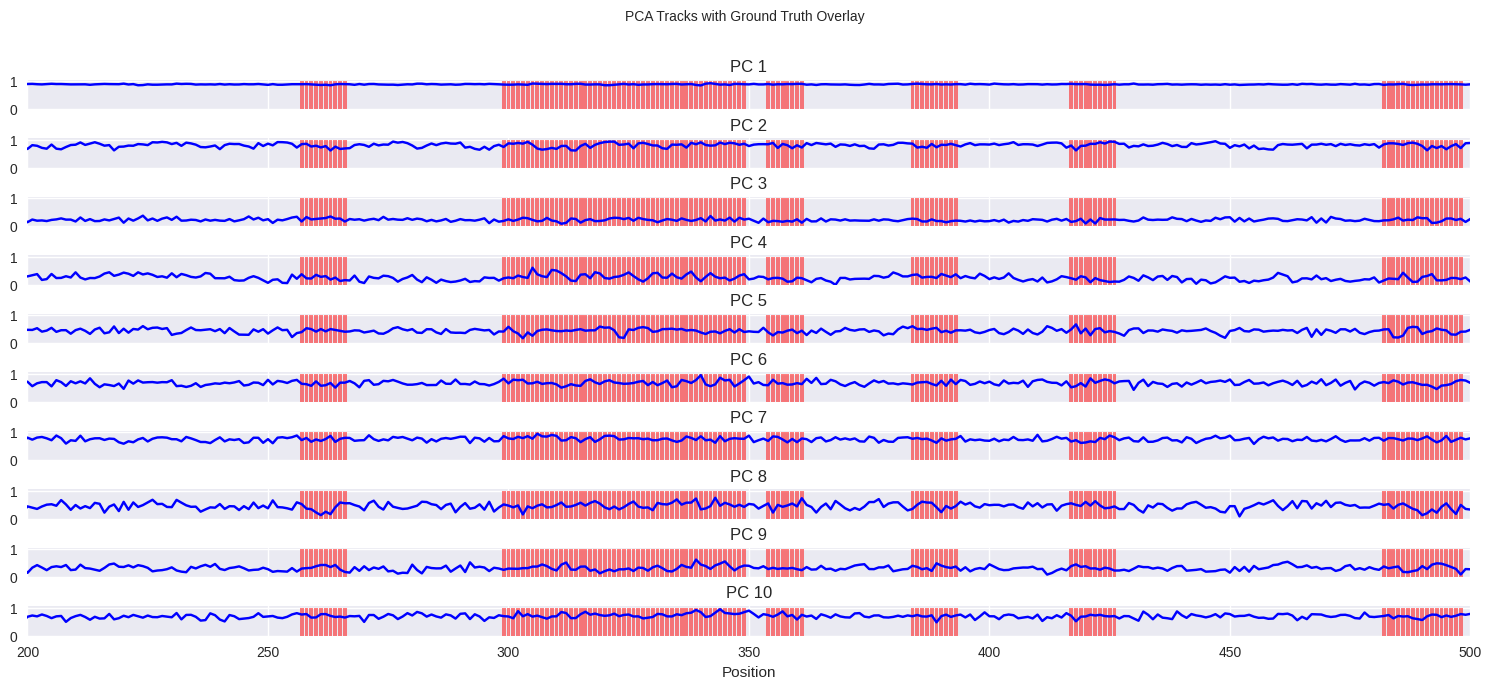

In [ ]:
# Genomic Track Matplotlib
ground_truth_track = ground_truth[11,:,57].astype(int)
plt.figure(figsize=(17, 10))
fig,axs = plt.subplots(figsize=(15, 7),nrows=10, ncols=1, sharex=True)
plt.suptitle('PCA Tracks with Ground Truth Overlay', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.style.use('seaborn-v0_8')
plt.xlabel('Position')
for pc in range(10):
    axs[pc].set_title(f'PC {pc+1}')
    axs[pc].set_xlim(200, 500)
    continuous_track = pca_k_values_reshaped[11,:,pc]
    continuous_track = (continuous_track - continuous_track.min()) / (continuous_track.max() - continuous_track.min())
    axs[pc].plot(continuous_track, label=f'PC {pc+1}', color='blue')
    axs[pc].grid(True)
    axs[pc].bar(range(len(ground_truth_track)), ground_truth_track, color='red', alpha=0.5, label='Ground Truth')

<BarContainer object of 1003 artists>

<Figure size 1700x1000 with 0 Axes>

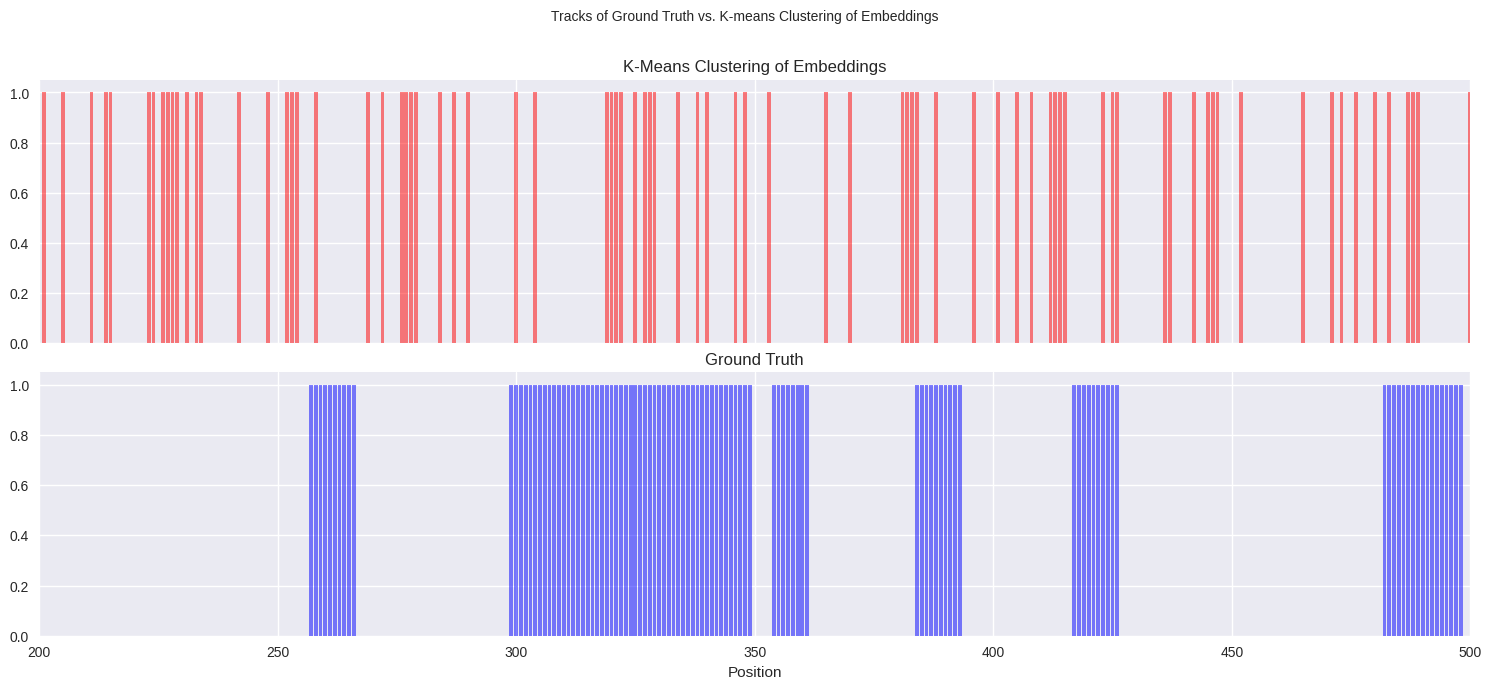

In [18]:
# Genomic Track Matplotlib Clustering
plt.figure(figsize=(17, 10))
fig,axs = plt.subplots(figsize=(15, 7),nrows=2, ncols=1, sharex=True)
plt.suptitle('Tracks of Ground Truth vs. K-means Clustering of Embeddings', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.style.use('seaborn-v0_8')
plt.xlabel('Position')
axs[0].set_title(f'K-Means Clustering of Embeddings')
axs[0].set_xlim(200, 500)
clustering_track = clustering_raw[11,:,0]
axs[0].bar(range(len(clustering_track)), clustering_track, color='red', alpha=0.5, label='Clustering Raw')
axs[1].set_title(f'Ground Truth')
axs[1].set_xlim(200, 500)
ground_truth_track = ground_truth[11,:,57].astype(int)
axs[1].grid(True)
axs[1].bar(range(len(ground_truth_track)), ground_truth_track, color='blue', alpha=0.5, label='Ground Truth')


In [21]:
cluster_colors = {
    0: "red",
    1: "green",
    2: "blue",
    3: "yellow",
    4: "cyan",
    5: "magenta",
    6: "orange",
    7: "purple",
    8: "brown",
    9: "pink",
    10: "gray"

}

<BarContainer object of 1003 artists>

<Figure size 1700x1000 with 0 Axes>

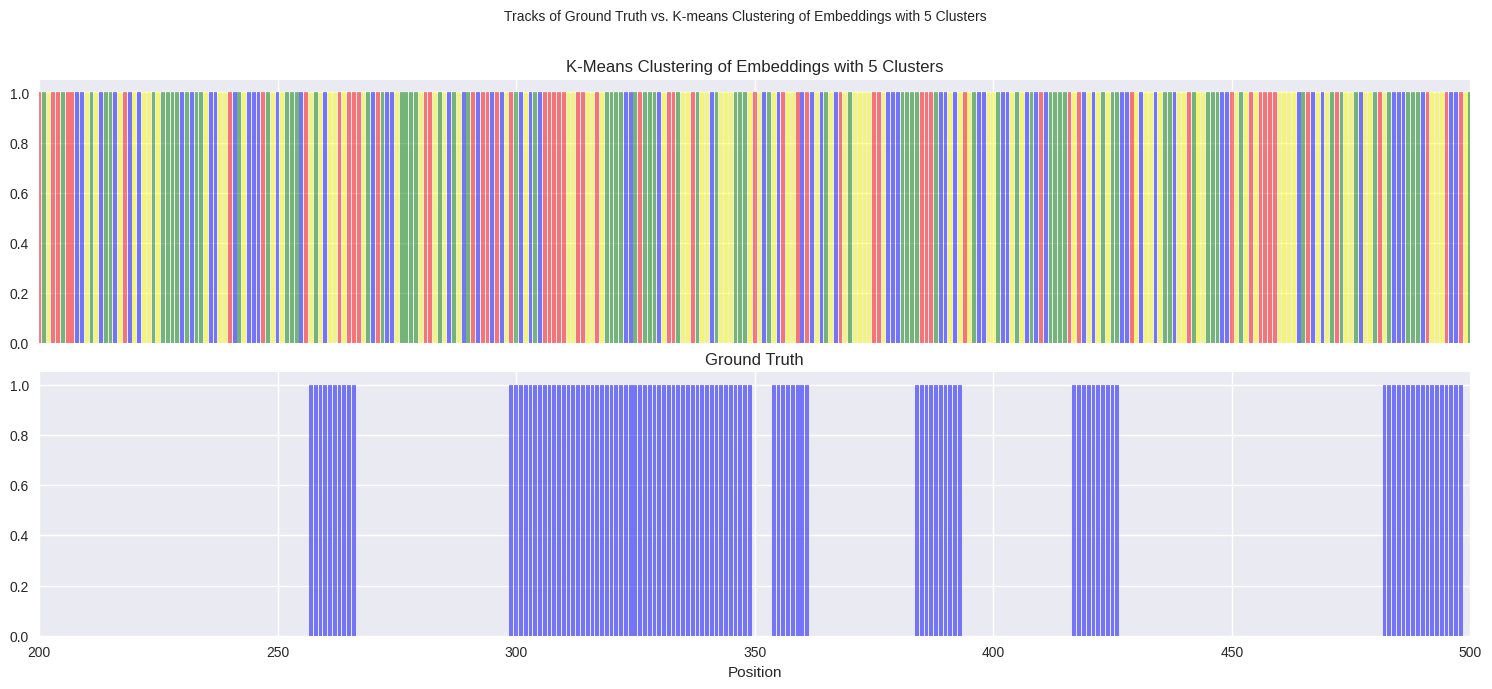

In [32]:
# Plot k=10 Clustering
plt.figure(figsize=(17, 10))
fig,axs = plt.subplots(figsize=(15, 7),nrows=2, ncols=1, sharex=True)
plt.suptitle('Tracks of Ground Truth vs. K-means Clustering of Embeddings with 5 Clusters', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.style.use('seaborn-v0_8')
plt.xlabel('Position')
axs[0].set_title(f'K-Means Clustering of Embeddings with 5 Clusters')
axs[0].set_xlim(200, 500)
clustering_track = clustering_5[11,:,0]
# Different Color bar according to cluster label in clustering_10
axs[0].bar(range(len(clustering_track)), 1, color=[cluster_colors[c] for c in clustering_track], alpha=0.5, label='Clustering 10')
axs[1].set_title(f'Ground Truth')
axs[1].set_xlim(200, 500)
ground_truth_track = ground_truth[11,:,57].astype(int)
axs[1].grid(True)
axs[1].bar(range(len(ground_truth_track)), ground_truth_track, color='blue', alpha=0.5, label='Ground Truth')
